

 

With this I achieved an accuracy of 97.16% on validation set.


In [1]:
import tensorflow as tf
import keras
import os
import shutil
import cv2
from tqdm import tqdm

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [10]:
img_path = 'C:\\Users\\tanvi\\Downloads\\indian-sign-language-translation-letters-n-digits'

for class1 in os.listdir(img_path):
    num_images = len(os.listdir(os.path.join(img_path,class1)))
    for (n,filename) in enumerate(os.listdir(os.path.join(img_path,class1))):
        img = os.path.join(img_path,class1,filename)
        if not os.path.exists('test/'+class1+'/'):
            os.makedirs('test/'+class1+'/')
            os.makedirs('train/'+class1+'/')
            os.makedirs('val/'+class1+'/')
        if n < int(0.1 * num_images):
            shutil.copy(img,'test/'+class1+'/'+filename)
        elif n < int(0.8 * num_images):
            shutil.copy(img,'train/'+class1+'/'+filename)
        else:
            shutil.copy(img,'val/'+class1+'/'+filename)

In [11]:
def load_data(image_dir):
    images = []
    y = []
    classNum = 0
    for class1 in tqdm(os.listdir(image_dir)):
        for file_name in os.listdir(os.path.join(image_dir,class1)):
            images.append(cv2.imread(os.path.join(image_dir,class1,file_name)))
            y.append(classNum)
        classNum += 1
    print(f'Loaded {len(images)} images from {image_dir} directory')
    images = np.array(images)
    y = np.array(y)
    return images,y

In [12]:
_, _ = load_data('train/')
test_images,test_labels = load_data('test/')
_, _ = load_data('val/')

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:54<00:00,  1.67s/it]
C:\Users\tanvi\AppData\Local\Temp\ipykernel_17304\1855462701.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


Loaded 7527 images from train/ directory


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.02it/s]


Loaded 1074 images from test/ directory


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.09it/s]

Loaded 2151 images from val/ directory


In [13]:
arr = [i for i in range(10)] + [chr(ord('a')+i) for i in range(26)]
arr.remove('v')
arr.remove('h')
arr.remove('j')
label_dicts = {i:arr[i] for i in range(len(arr))}
label_dicts

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'i',
 18: 'k',
 19: 'l',
 20: 'm',
 21: 'n',
 22: 'o',
 23: 'p',
 24: 'q',
 25: 'r',
 26: 's',
 27: 't',
 28: 'u',
 29: 'w',
 30: 'x',
 31: 'y',
 32: 'z'}

In [14]:
def show_samples(X,y,n=30):
    classes = np.unique(y)
    classNo = 0
    for class1 in classes:
        imgs = X[y == class1][:n]
        j = 10
        i = n // 10
        plt.figure(figsize=(15,1))
        for (c,img) in enumerate(imgs,1):
            plt.subplot(i,j,c)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f'Digit/Letter: {label_dicts[class1]}')
        classNo += 1
        if classNo == 15: 
            break

In [15]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.05,
        zoom_range=(0.8,1.2),
        width_shift_range=0.05,
        height_shift_range=0.05,
        rotation_range=30,
        brightness_range=(0.5,1.5),
        channel_shift_range=1,
        horizontal_flip=True)

train_generator = datagen.flow_from_directory(
        'train/',
        target_size=(224,224),
        batch_size=350,
        class_mode='categorical')
valid_generator = datagen.flow_from_directory(
        'val/',
        target_size=(224,224),
        batch_size=100,
        class_mode='categorical')
# plt.imshow(train_generator.next()[0].reshape(140,160,3))

Found 7527 images belonging to 33 classes.
Found 2151 images belonging to 33 classes.


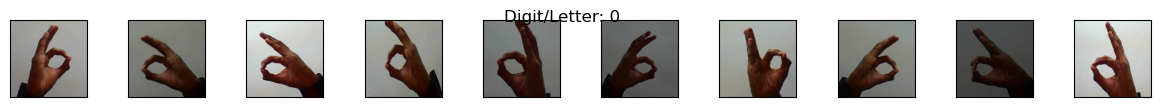

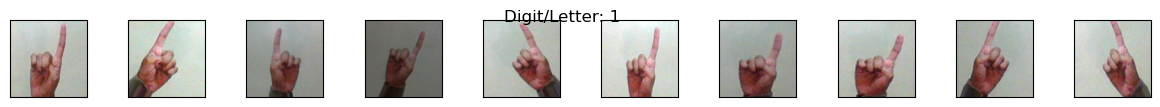

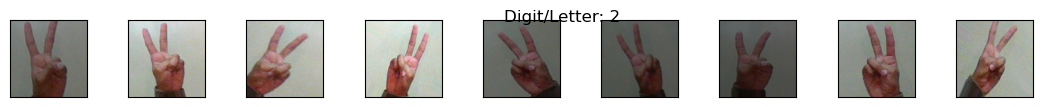

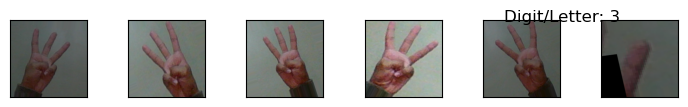

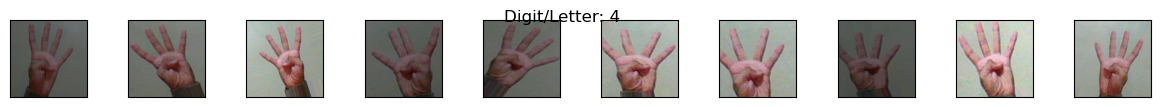

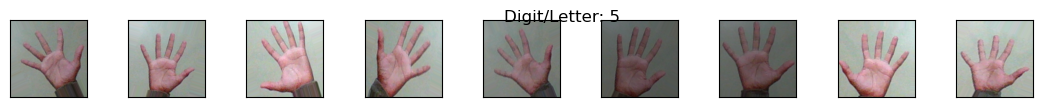

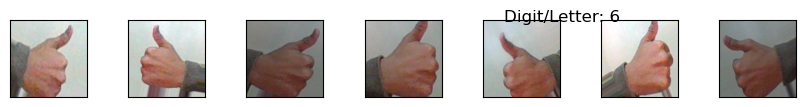

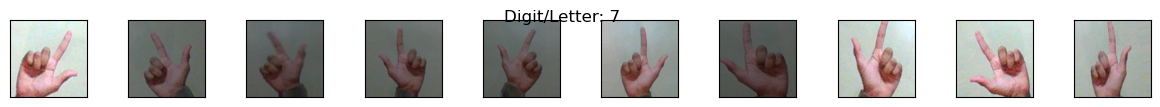

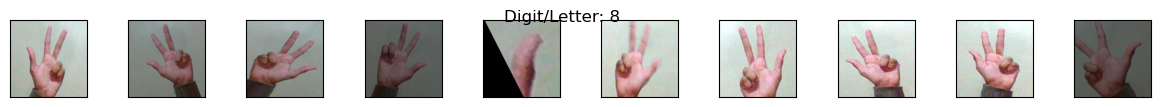

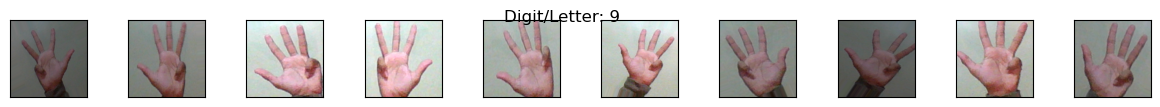

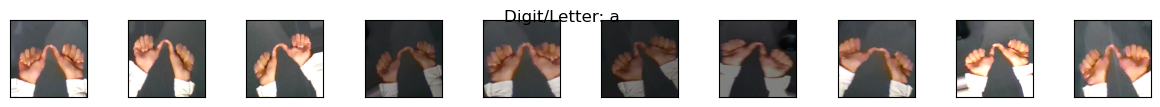

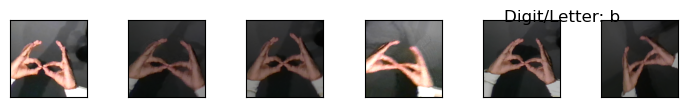

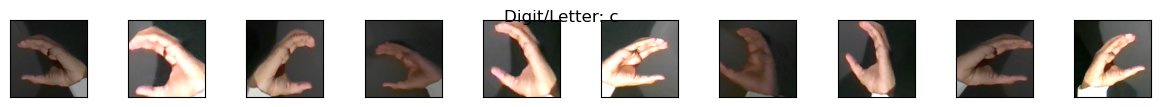

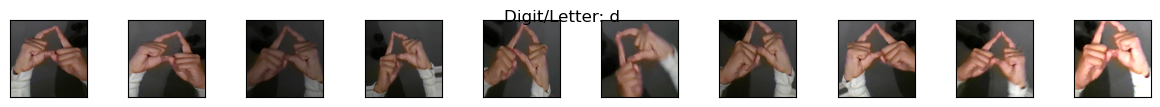

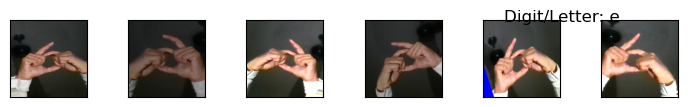

In [16]:
batch1 = train_generator.next()
show_samples(batch1[0], batch1[1].argmax(axis=1),n=10)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

In [18]:
model = Sequential()

model.add(Conv2D(16,kernel_size=8,activation='relu',input_shape=(224,224,3),padding='same'))
model.add(MaxPooling2D(pool_size=(8,8),strides=(8,8),padding='same'))
model.add(Conv2D(32,kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4),padding='same'))
model.add(Conv2D(64,kernel_size=3,activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(len(label_dicts),activation='softmax'))

In [19]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=8000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
train_step_size = train_generator.n//train_generator.batch_size
val_step_size = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_step_size,
        validation_data=valid_generator,
        validation_steps=val_step_size,
        epochs=15)

C:\Users\tanvi\AppData\Local\Temp\ipykernel_17304\94071696.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
21/21 [==============================] - 540s 25s/step - loss: 2.9975 - accuracy: 0.1879 - val_loss: 1.9026 - val_accuracy: 0.4519
Epoch 2/15
21/21 [==============================] - 485s 23s/step - loss: 1.3192 - accuracy: 0.6037 - val_loss: 0.8093 - val_accuracy: 0.7538
Epoch 3/15
21/21 [==============================] - 537s 25s/step - loss: 0.5298 - accuracy: 0.8346 - val_loss: 0.5358 - val_accuracy: 0.8248
Epoch 4/15
21/21 [==============================] - 494s 23s/step - loss: 0.3618 - accuracy: 0.8816 - val_loss: 0.3853 - val_accuracy: 0.8819
Epoch 5/15
21/21 [==============================] - 485s 23s/step - loss: 0.2494 - accuracy: 0.9253 - val_loss: 0.3394 - val_accuracy: 0.9181
Epoch 6/15
21/21 [==============================] - 525s 25s/step - loss: 0.1996 - accuracy: 0.9386 - val_loss: 0.3166 - val_accuracy: 0.9033
Epoch 7/15
21/21 [==============================] - 650s 31s/step - loss: 0.1682 - accuracy: 0.9489 - val_loss: 0.2968 - val_accuracy: 0.9100
Epoch 

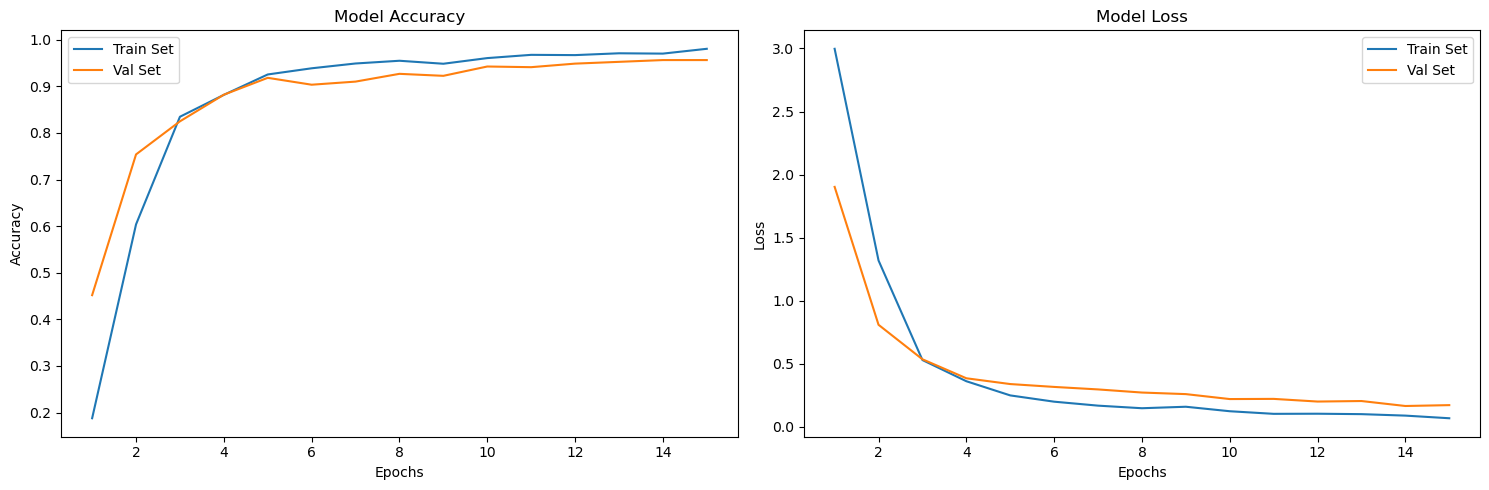

In [21]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [22]:
model.evaluate_generator(valid_generator)

C:\Users\tanvi\AppData\Local\Temp\ipykernel_17304\992553626.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(valid_generator)


[0.17632563412189484, 0.9549046754837036]

In [23]:
model.save('TUSHALJAIN.h5')

In [25]:
from tensorflow.keras.models import load_model
model = load_model('TUSHALJAIN.h5')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      3088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0